# Prerequisite

In [1]:
# !pip install scenic
# !pip install einops
!pip install --upgrade keras

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import keras

2024-07-26 11:43:08.328836: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
# Reset the plotly graph
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# Initialize plotly notebook mode
init_notebook_mode(connected=True)

# Load Dataset

# Create a pd for storing data info

In [19]:
def create_df(ab_fp,nor_fp):
  data_list = []
  for fn in os.listdir(ab_fp):
    video_path = os.path.join(ab_fp,fn)
    data_list.append((video_path,'Abnormal'))

  for fn in os.listdir(nor_fp):
    video_path = os.path.join(nor_fp,fn)
    data_list.append((video_path,'Normal'))
  return data_list


import pandas as pd
abnormal_fp = '/kaggle/input/dataset-cnn-gru/train/Abnormal'
normal_fp = '/kaggle/input/dataset-cnn-gru/train/Normal'
action_data_list = create_df(abnormal_fp,normal_fp)
df_action = pd.DataFrame(action_data_list, columns=['file_path', 'label'])
df_action = df_action.sample(frac=1, random_state=42).reset_index(drop=True)


## Split dataset

In [ ]:
from sklearn.model_selection import train_test_split

# split with sklearn
df_train, df_test = train_test_split(df_action, test_size=0.1, shuffle=True, random_state=42)


# Store to pkl files
- Since the spatio extracting process may take longer time (prbbly 1 hrs plus), hence we extract the extracted feature to pickle files for temporal modeling

In [58]:
!touch /kaggle/working/test_data.pkl
!touch /kaggle/working/test_labels.pkl
!touch /kaggle/working/train_data.pkl
!touch /kaggle/working/train_labels.pkl

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [59]:
import pickle
with open('/kaggle/working/test_data.pkl', 'wb') as file:
    pickle.dump(test_data, file)

In [60]:
with open('/kaggle/working/test_labels.pkl', 'wb') as file:
    pickle.dump(test_labels, file)

In [61]:
with open('/kaggle/working/train_data.pkl', 'wb') as file:
    pickle.dump(train_data, file)

In [62]:
with open('/kaggle/working/train_labels.pkl', 'wb') as file:
    pickle.dump(train_labels, file)

# Reload from PKL files

In [3]:
import pickle
from tqdm import tqdm

# Load the data
with open('/kaggle/input/cnn-gru-pkl2/test_data.pkl', 'rb') as file:
    loaded_vid_list = pickle.load(file)

# Initialize an empty list to hold the test data
test_data = []

# Use tqdm to create a progress bar
for x in tqdm(range(len(loaded_vid_list)), desc='Loading Data'):
    try:
        array_a_loaded = loaded_vid_list[x]
        test_data.append(array_a_loaded)
    except IndexError:
        print('End of data reached!')
        break

# Convert the list to a tuple
test_data = tuple(test_data)


Loading Data: 100%|██████████| 2/2 [00:00<00:00, 24036.13it/s]


In [4]:
import pickle
from tqdm import tqdm
import numpy as np
# Load the data
with open('/kaggle/input/cnn-gru-pkl2/test_labels.pkl', 'rb') as file:
    loaded_vid_list = pickle.load(file)

# Initialize an empty list to hold the test data
test_labels = []

# Use tqdm to create a progress bar
for x in tqdm(range(len(loaded_vid_list)), desc='Loading Data'):
    try:
        array_a_loaded = loaded_vid_list[x]
        test_labels.append(array_a_loaded)
    except IndexError:
        print('End of data reached!')
        break

# Convert the list to a tuple
test_labels = np.array(test_labels)


Loading Data: 100%|██████████| 128/128 [00:00<00:00, 525314.00it/s]


In [5]:
import pickle
from tqdm import tqdm

# Load the data
with open('/kaggle/input/cnn-gru-pkl2/train_data.pkl', 'rb') as file:
    loaded_vid_list = pickle.load(file)

# Initialize an empty list to hold the test data
train_data = []

# Use tqdm to create a progress bar
for x in tqdm(range(len(loaded_vid_list)), desc='Loading Data'):
    try:
        array_a_loaded = loaded_vid_list[x]
        train_data.append(array_a_loaded)
    except IndexError:
        print('End of data reached!')
        break

# Convert the list to a tuple
train_data = tuple(train_data)


Loading Data: 100%|██████████| 2/2 [00:00<00:00, 19065.02it/s]


In [6]:
import pickle
from tqdm import tqdm
import numpy as np
# Load the data
with open('/kaggle/input/cnn-gru-pkl2/train_labels.pkl', 'rb') as file:
    loaded_vid_list = pickle.load(file)

# Initialize an empty list to hold the test data
train_labels = []

# Use tqdm to create a progress bar
for x in tqdm(range(len(loaded_vid_list)), desc='Loading Data'):
    try:
        array_a_loaded = loaded_vid_list[x]
        train_labels.append(array_a_loaded)
    except IndexError:
        print('End of data reached!')
        break

# Convert the list to a tuple
train_labels = np.array(train_labels)


Loading Data: 100%|██████████| 672/672 [00:00<00:00, 544441.24it/s]


# Inception V3 (Spatial extraction)

In [2]:
IMG_SIZE = 224 # change
BATCH_SIZE = 64
EPOCHS = 80 # change default is 40

MAX_SEQ_LENGTH = 40 # change
NUM_FEATURES = 2048

In [3]:
""" Download inception v3 pretrain weights """
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [26]:
def load_video(path):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            # frame = crop_center_square(frame)
            # frame = cv2.resize(frame, resize)
            # frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
    finally:
        cap.release()
    return np.array(frames)

In [37]:
custom_vocabulary = ['Normal', 'Abnormal']

# Create the StringLookup layer with the custom vocabulary
label_processor = keras.layers.StringLookup(
    vocabulary=custom_vocabulary,
    num_oov_indices=0  # No out-of-vocabulary indices in this case
)

In [45]:
def prepare_all_videos(df):
    num_samples = len(df)
    video_paths = df["file_path"].values.tolist()
    labels = df["label"].values
    labels = keras.ops.convert_to_numpy(label_processor(labels[..., None]))

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(path)
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(
            shape=(
                1,
                MAX_SEQ_LENGTH,
            ),
            dtype="bool",
        )
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :], verbose=0,
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(df_train)
test_data, test_labels = prepare_all_videos(df_test)

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (672, 40, 2048)
Frame masks in train set: (672, 40)


# GRU (before tuned)

In [104]:
from tensorflow.keras.callbacks import EarlyStopping
# clear backend
keras.backend.clear_session()

# Utility for our sequence model.
def get_sequence_model():

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(32,return_sequences=True)(x)
    x = keras.layers.GRU(64)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(2, activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        metrics=["accuracy"]
    )
    return rnn_model

# Utility for running experiments.
def run_experiment():
    early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=100,
        callbacks=[early_stopping],
    )

    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


history, sequence_model = run_experiment()

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.4874 - loss: 0.7163 - val_accuracy: 0.5297 - val_loss: 0.6791
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5658 - loss: 0.6648 - val_accuracy: 0.7723 - val_loss: 0.5899
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7139 - loss: 0.5739 - val_accuracy: 0.8663 - val_loss: 0.4584
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8012 - loss: 0.5157 - val_accuracy: 0.8861 - val_loss: 0.4351
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8528 - loss: 0.4395 - val_accuracy: 0.8911 - val_loss: 0.3736
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8759 - loss: 0.3709 - val_accuracy: 0.9505 - val_loss: 0.2646
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8924 - loss: 0.3365 - val_accuracy: 0.9752 - val_loss: 0.1955
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9829 - loss: 0.2192 - val_accuracy: 0.

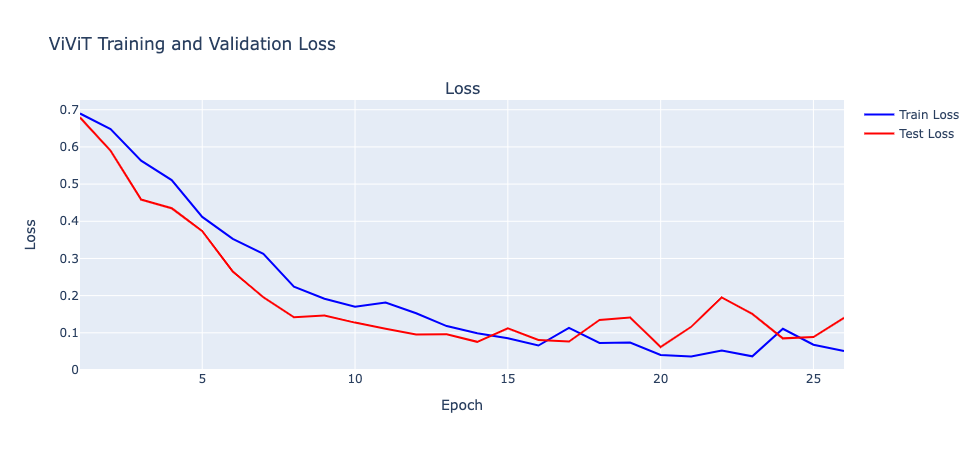

In [106]:
import plotly.graph_objs as go
import plotly.subplots as sp

# Sample data (replace these with your actual loss values)
loss2 = history.history['loss']
val_loss = history.history['val_loss']

epochs = list(range(1, len(loss2) + 1))

# Create subplots
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=('Accuracy', 'Loss'))

# Remove accuracy subplot by creating only one subplot for loss
fig = sp.make_subplots(rows=1, cols=1, subplot_titles=('Loss',))

# Add traces for loss
fig.add_trace(
    go.Scatter(x=epochs, y=loss2, mode='lines', name='Train Loss', line=dict(color='blue')),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=epochs, y=val_loss, mode='lines', name='Test Loss', line=dict(color='red')),
    row=1, col=1
)

# Update layout
fig.update_layout(
    title_text='ViViT Training and Validation Loss',
    showlegend=True,
    xaxis_title='Epoch',
    yaxis_title='Value'
)

# Update xaxis and yaxis titles for the loss subplot
fig.update_xaxes(title_text='Epoch', row=1, col=1)
fig.update_yaxes(title_text='Loss', dtick=0.1, row=1, col=1)  # Change dtick to desired step size for Loss

# Show figure
fig.show()

# GRU (After tuned)
- This training run after the hyperparameter process done

In [93]:
from tensorflow.keras.callbacks import EarlyStopping
# clear backend
keras.backend.clear_session()

# Utility for our sequence model.
def get_sequence_model():

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(32,return_sequences=True)(x)
    x = keras.layers.GRU(64)(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(2, activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=100,
        callbacks=[early_stopping],
    )

    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


history, sequence_model = run_experiment()

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.5740 - loss: 0.6846 - val_accuracy: 0.6733 - val_loss: 0.6053
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7025 - loss: 0.5980 - val_accuracy: 0.7624 - val_loss: 0.4975
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7444 - loss: 0.5369 - val_accuracy: 0.9356 - val_loss: 0.3779
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8694 - loss: 0.4160 - val_accuracy: 0.9653 - val_loss: 0.2905
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8774 - loss: 0.3585 - val_accuracy: 0.9604 - val_loss: 0.2644
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9402 - loss: 0.2742 - val_accuracy: 0.9802 - val_loss: 0.2003
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9511 - loss: 0.2282 - val_accuracy: 0.9851 - val_loss: 0.1580
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9636 - loss: 0.1948 - val_accuracy: 0.

## Loss Graph

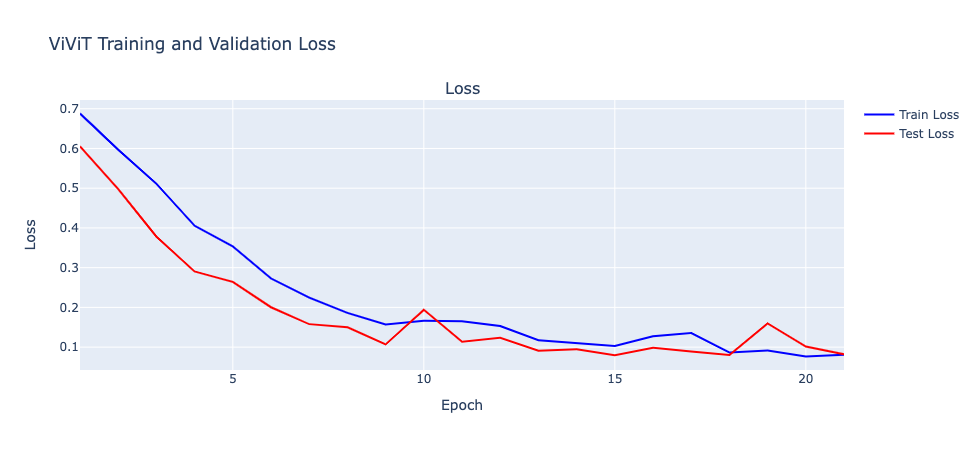

In [94]:
import plotly.graph_objs as go
import plotly.subplots as sp

# Sample data (replace these with your actual loss values)
loss2 = history.history['loss']
val_loss = history.history['val_loss']

epochs = list(range(1, len(loss2) + 1))

# Create subplots
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=('Accuracy', 'Loss'))

# Remove accuracy subplot by creating only one subplot for loss
fig = sp.make_subplots(rows=1, cols=1, subplot_titles=('Loss',))

# Add traces for loss
fig.add_trace(
    go.Scatter(x=epochs, y=loss2, mode='lines', name='Train Loss', line=dict(color='blue')),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=epochs, y=val_loss, mode='lines', name='Test Loss', line=dict(color='red')),
    row=1, col=1
)

# Update layout
fig.update_layout(
    title_text='ViViT Training and Validation Loss',
    showlegend=True,
    xaxis_title='Epoch',
    yaxis_title='Value'
)

# Update xaxis and yaxis titles for the loss subplot
fig.update_xaxes(title_text='Epoch', row=1, col=1)
fig.update_yaxes(title_text='Loss', dtick=0.1, row=1, col=1)  # Change dtick to desired step size for Loss

# Show figure
fig.show()

## Confusion Matrix

In [ ]:
import plotly.graph_objects as go
import numpy as np
import tensorflow as tf

# Assuming `test_data` and `test_labels` are already defined
def generate_predictions(model, data):
    predictions = model.predict(data)
    return np.argmax(predictions, axis=1)

# Generate predictions
predicted_labels = generate_predictions(sequence_model, [test_data[0], test_data[1]])
z = tf.math.confusion_matrix(labels=test_labels, predictions=predicted_labels)

# Convert the confusion matrix tensor to a NumPy array
conf_matrix_np = z.numpy()

# Create the heatmap
fig = go.Figure(data=go.Heatmap(
    z=conf_matrix_np,
    x=np.arange(conf_matrix_np.shape[1]),  # Assuming class labels are numeric
    y=np.arange(conf_matrix_np.shape[0]),  # Assuming class labels are numeric
    colorscale='Blues',
    showscale=True,
    text=conf_matrix_np,  # Annotate with the values
    texttemplate="%{text}",  # Format text
    textfont={"color": "black"}  # Set text color
))

# Update layout
fig.update_layout(
    title='Confusion Matrix - Test Set',
    xaxis_title='Predicted Labels',
    yaxis_title='True Labels',
    xaxis=dict(tickvals=np.arange(conf_matrix_np.shape[1]), ticktext=np.arange(conf_matrix_np.shape[1])),
    yaxis=dict(tickvals=np.arange(conf_matrix_np.shape[0]), ticktext=np.arange(conf_matrix_np.shape[0])),
    width=800,
    height=600
)

fig.show()


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


## Classification Report

In [96]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(test_labels, predicted_labels)
report = classification_report(test_labels, predicted_labels, output_dict=True)

precision = report['1']['precision']
recall = report['1']['recall']
f1_score = report['1']['f1-score']

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.97
Precision: 0.93
Recall: 1.00
F1 Score: 0.97


# Hyper parameter tuning

In [111]:
import keras_tuner as kt

# Utility for our sequence model.
def build_sequence_model(hp):
    
    # Setup params for hyper tune [learning_rate, dropout]
    DROPOUT_RATE = hp.Float('dropout_rate', min_value=0.2, max_value=0.8, step=0.1) #NOTE: Total 7
    LEARNING_RATE = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5]) #NOTE: total 4
    
    
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(32,return_sequences=True)(x)
    x = keras.layers.GRU(64)(x)
    x = keras.layers.Dropout(DROPOUT_RATE)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(2, activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        metrics=["accuracy"]
    )
    return rnn_model

In [112]:
from tensorflow.keras import layers, models
import keras_tuner as kt

tuner = kt.GridSearch(
    hypermodel=build_sequence_model,
    objective="val_accuracy",
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
    directory='my_dir',
    project_name="CNN-GRU_GridSearch",
)

In [113]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.8, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}


In [114]:
tuner.search([train_data[0], train_data[1]], train_labels, epochs=40, validation_data=([test_data[0], test_data[1]], test_labels))
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""The hyperparameter grid serach is completed.The optimal parameter for
dropput is {round(best_hps.get('dropout_rate'),1)} and for the learning rate is {best_hps.get('learning_rate')}""")

Trial 28 Complete [00h 00m 30s]
val_accuracy: 0.8700334211920929

Best val_accuracy So Far: 0.96883454690909091
Total elapsed time: 00h 19m 37s

The hyperparameter grid serach is completed.The optimal parameter for
dropput is 0.5 and for the learning rate is 1e-3



# Save model

In [102]:
sequence_model.save('CNN-RNN_26Jul_1.keras')

# Demostration
- Please ensure that the inceptionv3 pretrain had been loaded first before running this code

In [9]:
import numpy as np
import os
import cv2

def load_all_frames(video_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        return {'frames':None,'frames_dim':None,'success':False}
    frames_dims = []
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        h,w,c = frame.shape
        frames_dims.append(list([0,h,w,c]))
        # frame = cv2.resize(frame, (128, 128), interpolation=cv2.INTER_CUBIC)
        frames.append(frame)

    cap.release()
    return {'frames':np.asarray(frames),'frames_dim':frames_dims,'success':True}

def trim_video_frames(video,max_frame):
    '''
    Args:
        video: video (collection of frames)
        max_frame: max number of frames
    '''
    f,_,_,_ = video.shape
    startf = f//2 - max_frame//2
    return video[startf:startf+max_frame, :, :, :]

def load_video(video_path):
    videos=[]
    video_dims = []

    load_data = load_all_frames(video_path)
    video = load_data['frames']

    dims = np.asarray(load_data['frames_dim'])
    dims[:,0] = video.shape[0]
    video_dims += dims.tolist()
    return trim_video_frames(video,40)

def prepare_video(vid_path):
    # Prepare array
    frame_mask = np.zeros(shape=(1, 40), dtype="bool")
    frame_feature = np.zeros(shape=(1, 40, 2048), dtype="float32")

    # Load video
    frames = load_video(vid_path)
    # temp_frame_mask = np.zeros(shape=(1, 40), dtype="bool")
    # temp_frame_features = np.zeros(shape=(1, 40, 2048), dtype="float32")

    # Initialize temporary arrays for current video
    temp_frame_mask = np.zeros(shape=(1, 40), dtype=bool)
    temp_frame_features = np.zeros(shape=(1, 40, 2048), dtype=np.float32)

    # Extract features from frames
    for i, f in enumerate(frames):
      # print(np.array(f).shape)
      expand_f = tf.expand_dims(f, axis=0)
      temp_frame_features[0, i, :] = feature_extractor.predict(expand_f, verbose=0)
      temp_frame_mask[0, i] = 1  # Not masked



    return (temp_frame_features, temp_frame_mask)

import timeit  # speed benchmark purpose
st = timeit.default_timer()
test = prepare_video('/Users/linzhanyao/Project/Human-Anomaly-Detection/Dataset/Test_dataset/abnormal/video_18.avi')
et = timeit.default_timer()
print(f'Time take={et-st}')
print(f'Frame features in test video: {test[0].shape}')
print(f'Frame mask in test vieo: {test[1].shape}')

Time take=4.194300422008382
Frame features in test video: (1, 40, 2048)
Frame mask in test vieo: (1, 40)


In [ ]:
# load model
prev_model = tf.keras.models.load_model('/kaggle/working/CNN-RNN_26Jul_1.keras')

In [ ]:
# make pred
label_dict = {0:'Normal', 1:'Abnormal'} 
output = prev_model.predict([test[0],test[1]])[0]
print(output)
pred = np.argmax(output.tolist(),axis=0)
print(label_dict[pred])